In [72]:
import numpy as np
import pandas as pd
import xgboost as xgb
import pickle

# params
n_fold = 5
# xvars = ['quality','dow', 'act_prev','daytype','stress_prev','energy_prev','focus_prev','mood_prev','quality_prev','mood_prev2','quality_prev2','mood_prev3','quality_prev3']
xvars = ['quality','quality_prev','mood_prev']
yvars = ['mood']

# read data
with open('data.dat') as f:
    data, subjects = pickle.load(f)
f.close()

# concatenatig into a single dataframe
data_all = pd.concat(data, axis=0)
data_all = data_all.reset_index(drop=True)

# data = data[:10]

# personal analysis

r2_train = np.array([])
r2_test = np.array([])

for i in range(len(data)):
    
    
    data[i] = data[i][xvars+yvars]
    data[i] = data[i].dropna()
    data[i] = data[i].reset_index(drop=True)
    
    if data[i].shape[0]<20:
        print 'skipping subject '+subjects[i]
        continue
    
    x = data[i][xvars]
    y = data[i][yvars]
    
    fold_size = np.floor(data[i].shape[0]/float(n_fold))
    
    r2_row_train = np.zeros([1,n_fold])
    r2_row_test = np.zeros([1,n_fold])
    
    for j in range(n_fold):
        
        xtest = x.loc[j*fold_size:(j+1)*fold_size-1,:]
        xtest = xtest.reset_index(drop=True)
        ytest = y.loc[j*fold_size:(j+1)*fold_size-1]
        ytest = ytest.reset_index(drop=True)
        
        xtrain = x.loc[0:j*fold_size-1,:]
        xtrain = pd.concat([xtrain, x.loc[(j+1)*fold_size:,:]], axis=0)
        xtrain = xtrain.reset_index(drop=True)

        ytrain = y.loc[0:j*fold_size-1]
        ytrain = pd.concat([ytrain, y.loc[(j+1)*fold_size:]], axis=0)
        ytrain = ytrain.reset_index(drop=True)
        
        if np.var(np.array(ytrain))==0:
            print 'skipping fold due to no variation in outcome'
            r2_row_train[0,j] = np.nan
            r2_row_test[0,j] = np.nan
            continue
        
        gbm = xgb.XGBRegressor(max_depth=4, learning_rate=0.05, n_estimators=200, silent=True, objective='reg:linear', nthread=-1,\
                         gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1,\
                         reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
        gbm.fit(xtrain, ytrain, eval_set=[(xtrain,ytrain),(xtest, ytest)], eval_metric='rmse', verbose=False)
        
        # training performance
        ypred_train = gbm.predict(xtrain).reshape(xtrain.shape[0],1)
        r2_row_train[0,j] = 1 - (np.sum(np.power(ypred_train-np.array(ytrain),2))/\
                                 np.sum(np.power(np.mean(np.array(ytrain))-np.array(ytrain),2)))
        
        # test performance
        ypred_test = gbm.predict(xtest).reshape(xtest.shape[0],1)
        r2_row_test[0,j] = 1 - (np.sum(np.power(ypred_test-np.array(ytest),2))/\
                                np.sum(np.power(np.mean(np.array(ytrain))-np.array(ytest),2)))
        
    if r2_test.size==0:
        r2_train = r2_row_train
        r2_test = r2_row_test
    else:
        r2_train = np.append(r2_train, r2_row_train, axis=0)
        r2_test = np.append(r2_test, r2_row_test, axis=0)
        
# mixed analysis



skipping subject 1374066
skipping subject EW057DI
skipping subject 1549226
skipping subject 1428949
skipping subject 872451
skipping subject 1569370
skipping subject 1128660
skipping subject 1272711
skipping subject 1336140
skipping fold due to no variation in outcome
skipping subject 1294671
skipping subject 1334243
skipping subject 1560782
skipping subject 555220
skipping subject 639010
skipping subject 1230637


training mean R2 = 0.273877323144
test mean R2 = -0.130447550566


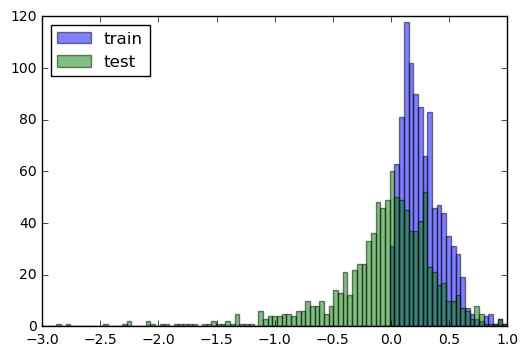

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten(), bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten(), bins, alpha=0.5, label='test');
plt.legend(loc='upper left')

training mean R2 = 0.851012876406
test mean R2 = -0.606042365809


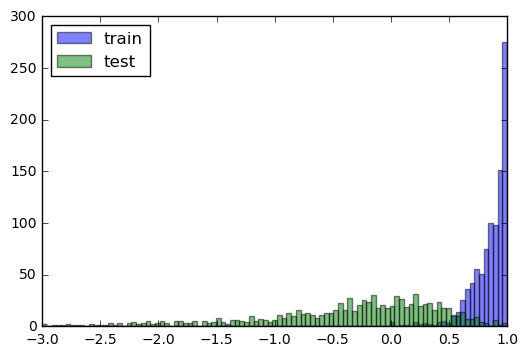

In [82]:
import matplotlib.pyplot as plt
%matplotlib inline

print 'training mean R2 = {}'.format(np.nanmean(r2_train))
print 'test mean R2 = {}'.format(np.nanmean(r2_test))

bins = np.linspace(-3, 1, 100)
plt.hist(r2_train.flatten()[~np.isnan(r2_train.flatten())], bins, alpha=0.5, label='train');
plt.hist(r2_test.flatten()[~np.isnan(r2_test.flatten())], bins, alpha=0.5, label='test');
plt.legend(loc='upper left')